In [4]:
!pip install rasterio shapely scikit-image torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 71.9 MB/s eta 0:00:00


In [5]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import box

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cpu


# Recorte de Rasters


In [7]:
def recortar_raster_por_coordenadas(input_raster, minx, miny, maxx, maxy, output_raster):
    """
    Recorta um raster usando um retângulo de coordenadas geográficas.
    """
    bbox = box(minx, miny, maxx, maxy)
    geometries = [bbox]

    if not os.path.exists(input_raster):
        print(f"Erro: Arquivo de entrada não encontrado: {input_raster}")
        return None

    try:
        with rasterio.open(input_raster) as src:
            out_image, out_transform = mask(src, geometries, crop=True)
            out_meta = src.meta.copy()

            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            with rasterio.open(output_raster, "w", **out_meta) as dest:
                dest.write(out_image)

            print(f"✅ Recorte salvo em: {output_raster}")
            print(f"   Dimensões: {out_image.shape[1]} x {out_image.shape[2]}")
            return output_raster

    except ValueError as e:
        print(f"Erro ao recortar o raster: {e}")
        return None


In [8]:
# # Substitua pelos caminhos dos seus arquivos
# anadem_path = "ANADEM_AricanduvaBufferUTM.tif"
# geosampa_path = "MDTGeosampa_AricanduvaBufferUTM.tif"

# # Coordenadas de recorte (exemplo)
# minx_val, miny_val, maxx_val, maxy_val = 346000, 7391400, 347000, 7392400

# rec_anadem = recortar_raster_por_coordenadas(anadem_path, minx_val, miny_val, maxx_val, maxy_val, "recorte_anadem.tif")
# rec_geosampa = recortar_raster_por_coordenadas(geosampa_path, minx_val, miny_val, maxx_val, maxy_val, "recorte_geosampa.tif")


In [9]:
# numero dos pixels

with rasterio.open("recorte_anadem.tif") as src:
    shape = (src.height, src.width, src.count)
    print("Shape:", shape)
    total_pixels = src.height * src.width
    print("Total de pixels:", total_pixels)


Shape: (3345, 4022, 1)
Total de pixels: 13453590


#  Pré-Processamento

In [10]:
class SuperResTiffDataset(Dataset):
    def __init__(self, low_res_paths, high_res_paths, target_size=(128,128)):
        self.low_res_paths = low_res_paths
        self.high_res_paths = high_res_paths
        self.target_size = target_size

    def __len__(self):
        return len(self.low_res_paths)

    def __getitem__(self, idx):
        with rasterio.open(self.low_res_paths[idx]) as src:
            low_res = src.read(1).astype(np.float32)

        with rasterio.open(self.high_res_paths[idx]) as src:
            high_res = src.read(1).astype(np.float32)

        # Normalização
        low_res = (low_res - np.min(low_res)) / (np.max(low_res) - np.min(low_res) + 1e-8)
        high_res = (high_res - np.min(high_res)) / (np.max(high_res) - np.min(high_res) + 1e-8)

        # Tensores [1, H, W]
        low_res = torch.from_numpy(low_res).unsqueeze(0)
        high_res = torch.from_numpy(high_res).unsqueeze(0)

        # Redimensiona
        low_res = F.interpolate(low_res.unsqueeze(0), size=self.target_size, mode="bilinear", align_corners=False).squeeze(0)
        high_res = F.interpolate(high_res.unsqueeze(0), size=self.target_size, mode="bilinear", align_corners=False).squeeze(0)

        return low_res, high_res


# Arquitetura U-Net


In [11]:
def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNetFinal(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_filters=16):
        super().__init__()
        f = base_filters

        self.conv1 = conv_block(in_channels, f)
        self.conv2 = conv_block(f, f*2)
        self.conv3 = conv_block(f*2, f*4)
        self.conv4 = conv_block(f*4, f*8)

        self.pool = nn.MaxPool2d(2, 2)
        self.bottleneck = conv_block(f*8, f*16)

        self.up4 = nn.ConvTranspose2d(f*16, f*8, kernel_size=2, stride=2)
        self.conv_up4 = conv_block(f*16, f*8)

        self.up3 = nn.ConvTranspose2d(f*8, f*4, kernel_size=2, stride=2)
        self.conv_up3 = conv_block(f*8, f*4)

        self.up2 = nn.ConvTranspose2d(f*4, f*2, kernel_size=2, stride=2)
        self.conv_up2 = conv_block(f*4, f*2)

        self.up1 = nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2)
        self.conv_up1 = conv_block(f*2, f)

        self.final_conv = nn.Conv2d(f, out_channels, kernel_size=1)

    def forward(self, x):
        c1 = self.conv1(x); p1 = self.pool(c1)
        c2 = self.conv2(p1); p2 = self.pool(c2)
        c3 = self.conv3(p2); p3 = self.pool(c3)
        c4 = self.conv4(p3); p4 = self.pool(c4)
        b = self.bottleneck(p4)

        u4 = F.interpolate(self.up4(b), size=c4.size()[2:], mode='bilinear', align_corners=False)
        u4 = self.conv_up4(torch.cat([u4, c4], 1))

        u3 = F.interpolate(self.up3(u4), size=c3.size()[2:], mode='bilinear', align_corners=False)
        u3 = self.conv_up3(torch.cat([u3, c3], 1))

        u2 = F.interpolate(self.up2(u3), size=c2.size()[2:], mode='bilinear', align_corners=False)
        u2 = self.conv_up2(torch.cat([u2, c2], 1))

        u1 = F.interpolate(self.up1(u2), size=c1.size()[2:], mode='bilinear', align_corners=False)
        u1 = self.conv_up1(torch.cat([u1, c1], 1))

        return self.final_conv(u1)


# Treinamento

In [12]:
# low_res_files = [rec_anadem]
# high_res_files = [rec_geosampa]

low_res_files =["recorte_anadem.tif"]
high_res_files = ["recorte_geosampa.tif"]


dataset = SuperResTiffDataset(low_res_files, high_res_files, target_size=(128,128))
loader = DataLoader(dataset, batch_size=1, shuffle=True)

model = UNetFinal().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for low_res, high_res in loader:
        low_res, high_res = low_res.to(device), high_res.to(device)

        preds = model(low_res)
        loss = criterion(preds, high_res)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Época [{epoch+1}/{epochs}] | Loss: {epoch_loss:.6f}")

torch.save(model.state_dict(), "unet_superres.pth")


Época [1/50] | Loss: 0.095640
Época [2/50] | Loss: 0.094547
Época [3/50] | Loss: 0.093472
Época [4/50] | Loss: 0.092418
Época [5/50] | Loss: 0.091379
Época [6/50] | Loss: 0.090339
Época [7/50] | Loss: 0.089288
Época [8/50] | Loss: 0.088235
Época [9/50] | Loss: 0.087194
Época [10/50] | Loss: 0.086186
Época [11/50] | Loss: 0.085235
Época [12/50] | Loss: 0.084360
Época [13/50] | Loss: 0.083555
Época [14/50] | Loss: 0.082804
Época [15/50] | Loss: 0.082092
Época [16/50] | Loss: 0.081407
Época [17/50] | Loss: 0.080754
Época [18/50] | Loss: 0.080131
Época [19/50] | Loss: 0.079528
Época [20/50] | Loss: 0.078928
Época [21/50] | Loss: 0.078319
Época [22/50] | Loss: 0.077702
Época [23/50] | Loss: 0.077083
Época [24/50] | Loss: 0.076479
Época [25/50] | Loss: 0.075886
Época [26/50] | Loss: 0.075301
Época [27/50] | Loss: 0.074720
Época [28/50] | Loss: 0.074134
Época [29/50] | Loss: 0.073535
Época [30/50] | Loss: 0.072923
Época [31/50] | Loss: 0.072294
Época [32/50] | Loss: 0.071647
Época [33/50] | L

# Inferencia

In [13]:
def gerar_superres_tif(model, low_res_tif, out_path, device):
    model.eval()
    with rasterio.open(low_res_tif) as src:
        img = src.read(1).astype(np.float32)
        profile = src.profile

    img_norm = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    img_tensor = torch.from_numpy(img_norm).unsqueeze(0).unsqueeze(0).to(device)
    img_tensor = F.interpolate(img_tensor, size=(128,128), mode="bilinear", align_corners=False)

    with torch.no_grad():
        pred = model(img_tensor).cpu().squeeze().numpy()

    pred = pred * (np.max(img) - np.min(img)) + np.min(img)

    profile.update(dtype=rasterio.float32)
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(pred.astype(np.float32), 1)

    print(f"Super-resolução salva em: {out_path}")


In [14]:
gerar_superres_tif(model, "novo_recortearicanduva_teste2.tif", "saida.tif", device)

Super-resolução salva em: saida.tif


In [15]:
gerar_superres_tif(model, "ANADEM_AricanduvaBufferUTM.tif", "saida_aricanduva.tif", device)

Super-resolução salva em: saida_aricanduva.tif


# Avaliação

In [16]:
def avaliar_modelo(model, dataset, device):
    model.eval()
    mse_vals, psnr_vals, ssim_vals = [], [], []

    for low_res, high_res in dataset:
        low_res, high_res = low_res.unsqueeze(0).to(device), high_res.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(low_res).cpu().squeeze().numpy()
        gt = high_res.cpu().squeeze().numpy()

        mse_vals.append(mean_squared_error(gt, pred))
        psnr_vals.append(peak_signal_noise_ratio(gt, pred, data_range=1))
        ssim_vals.append(structural_similarity(gt, pred, data_range=1))

    return {
        "MSE": np.mean(mse_vals),
        "PSNR": np.mean(psnr_vals),
        "SSIM": np.mean(ssim_vals)
    }

metrics = avaliar_modelo(model, dataset, device)
print("📊 Métricas:", metrics)


📊 Métricas: {'MSE': np.float64(0.05043294190592869), 'PSNR': np.float64(12.972856973922113), 'SSIM': np.float64(0.380252596502986)}


In [17]:
def plotar_rasters(file_list):
    """
    Plota rasters de uma lista de arquivos .tif com o nome no título.
    """
    n = len(file_list)
    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))

    if n == 1:
        axs = [axs]  # garante que axs seja iterável

    for ax, file in zip(axs, file_list):
        with rasterio.open(file) as src:
            show(src, ax=ax, title=os.path.basename(file))

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


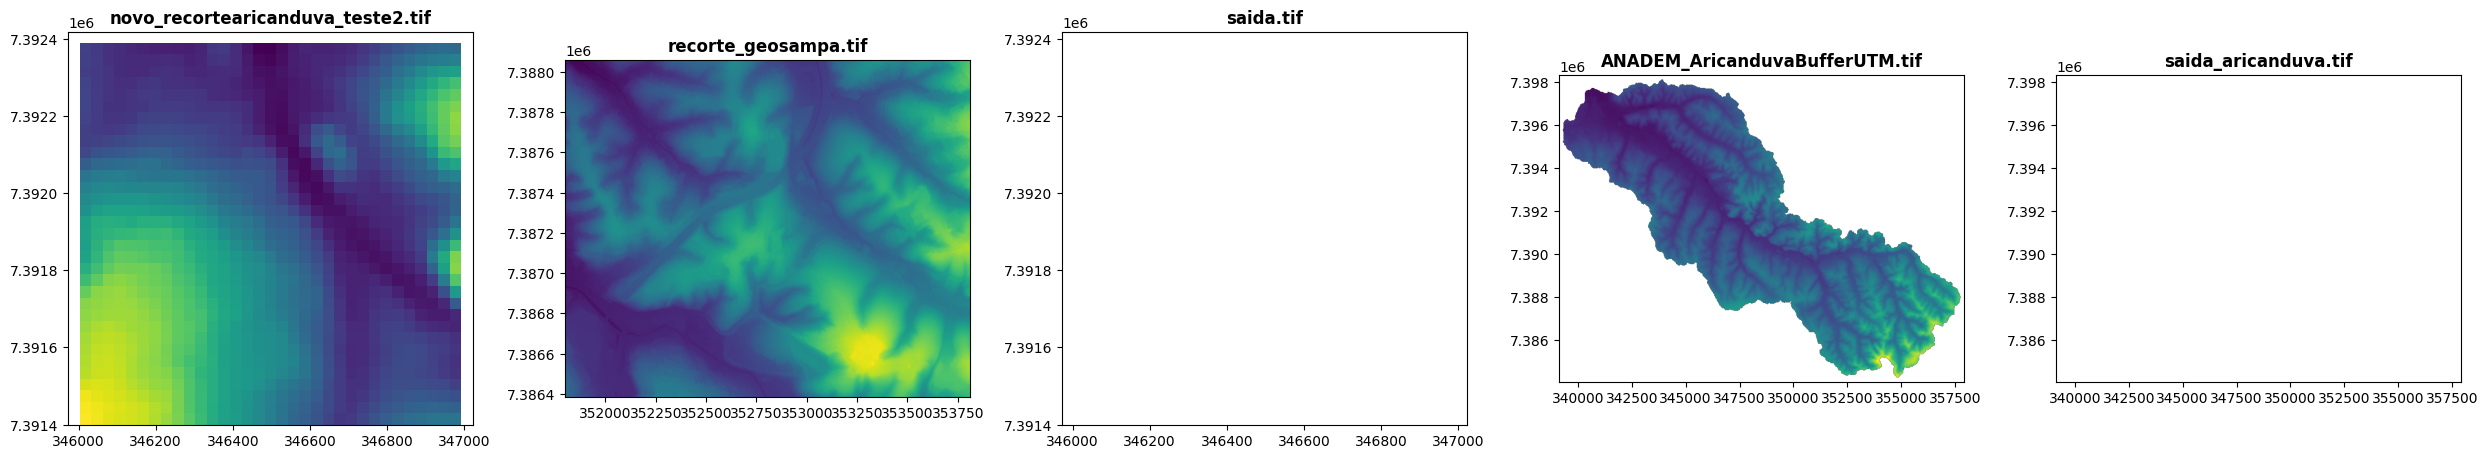

In [18]:
plotar_rasters([
    "novo_recortearicanduva_teste2.tif",
    "recorte_geosampa.tif",
    "saida.tif",
    "ANADEM_AricanduvaBufferUTM.tif",
    "saida_aricanduva.tif"
])

In [19]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import rasterio

def comparar_imagens(ref_path, pred_path):
    """
    Compara imagem de referência com predição do modelo.
    Mostra as imagens lado a lado e imprime métricas (MSE, PSNR, SSIM).
    """
    # Carrega imagens
    with rasterio.open(ref_path) as src:
        ref = src.read(1).astype(np.float32)
    with rasterio.open(pred_path) as src:
        pred = src.read(1).astype(np.float32)

    # Normaliza para [0,1] (necessário para métricas justas)
    ref_norm = (ref - np.min(ref)) / (np.max(ref) - np.min(ref) + 1e-8)
    pred_norm = (pred - np.min(pred)) / (np.max(pred) - np.min(pred) + 1e-8)

    # Calcula métricas
    mse_val = mean_squared_error(ref_norm, pred_norm)
    psnr_val = peak_signal_noise_ratio(ref_norm, pred_norm, data_range=1)
    ssim_val = structural_similarity(ref_norm, pred_norm, data_range=1)

    # Print métricas
    print("📊 Métricas:")
    print(f"   MSE  = {mse_val:.6f}")
    print(f"   PSNR = {psnr_val:.2f} dB")
    print(f"   SSIM = {ssim_val:.4f}")

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(ref, cmap='gray')
    axs[0].set_title("Imagem Referência")
    axs[0].axis("off")

    axs[1].imshow(pred, cmap='gray')
    axs[1].set_title(f"Super-Resolução\nMSE={mse_val:.4f}, PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    return {"MSE": mse_val, "PSNR": psnr_val, "SSIM": ssim_val}


# Performance

In [20]:
def benchmark(model, dataset, device):
    start = time.time()
    metrics = avaliar_modelo(model, dataset, device)
    elapsed = time.time() - start
    print(f"⏱ Tempo de avaliação: {elapsed:.2f}s")
    return metrics, elapsed

results, tempo = benchmark(model, dataset, device)
print("📊 Resultados:", results)


⏱ Tempo de avaliação: 0.25s
📊 Resultados: {'MSE': np.float64(0.05043294190592869), 'PSNR': np.float64(12.972856973922113), 'SSIM': np.float64(0.380252596502986)}
